This notebook is an adaption of https://adversarial-ml-tutorial.org/introduction/. Please refer to it for a more detailed explanation.

First, let's import some libraries and plot the image of the pig.

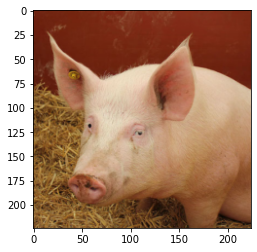

torch.Size([1, 3, 224, 224])


In [28]:
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
pig_tensor = preprocess(pig_img)[None, :, :, :]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1, 2, 0))
plt.show()
print(pig_tensor.shape)

In [18]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[
            None, :, None, None
        ]


# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval()

pred = model(norm(pig_tensor))

import json

with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i): x[1] for i, x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


Next, do a quick gradient ascent on the pig's loss and visualize the adversarial image.

In [26]:
import torch.optim as optim

epsilon = 2.0 / 255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) # 341 = hog
    loss += nn.CrossEntropyLoss()(pred, torch.LongTensor([404])) # 404 = airplane
    
    if t % 5 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    # Clamping to epsilon for PGD
    delta.data.clamp_(-epsilon, epsilon)

0 24.006046295166016
5 4.998350143432617
10 -0.3006401062011719
15 -3.872136354446411
20 -7.818149566650391
25 -11.672074317932129


True class probability: 2.553485103362618e-07
Predicted class:  airliner
Predicted probability: 0.5393072366714478


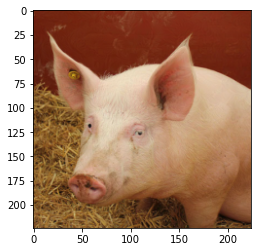

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


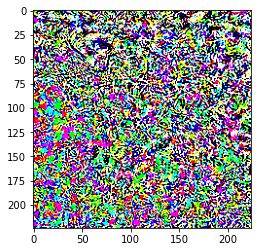

In [27]:
print("True class probability:", nn.Softmax(dim=1)(pred)[0, 341].item())

max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0, max_class].item())

plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1, 2, 0))
plt.show()

plt.imshow((1e6 * delta[0]).detach().numpy().transpose(1, 2, 0))
plt.show()